## supervise Multi Ai Agent Architecture

In [1]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [4]:
from langchain.chat_models import init_chat_model

llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000230A494DFA0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000230A43CFDA0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [2]:
class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [5]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [6]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [7]:
# ===================================
# Agent 1: Researcher (using Groq)
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [8]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [9]:
# ===================================
# Agent 3: Writer (using Groq)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [11]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [12]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()

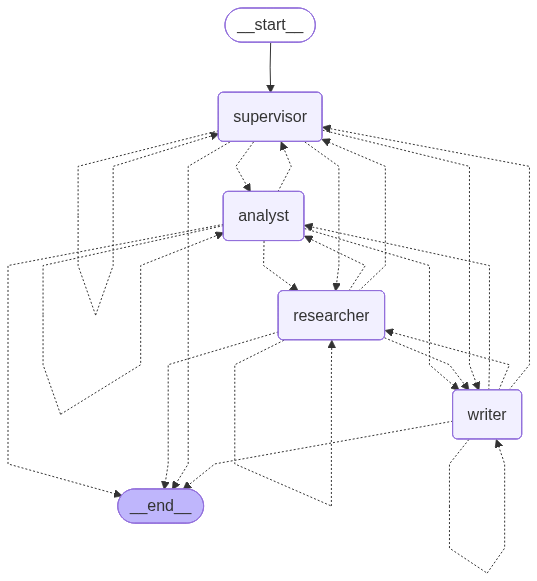

In [13]:
graph

In [14]:
response=graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

researcher
researcher
analyst
writer


In [15]:
response['final_report']

"\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-11-04 08:06\nTopic: 📊 Analyst: I've completed the analysis.\n\nTop insights:\n**Research on 'No Task'**\n\n**Key Insights and Patterns:**\n\n1. **Work-life balance:** The concept of 'no task' is often tied to work-life balance, with individuals seeking more leisure time or periods of rest to recharge.\n2. **Impact of technology:** The rise of remote work, automation, and artificial intelligence has led to increased flexibility and reduced workload for some individuals, potential...\n==================================================\n\n**Executive Report: The Concept of 'No Task'**\n\n**Date:** [Current Date]\n**Author:** [Your Name]\n**Analyst:** [Analyst's Name]\n\n**Executive Summary**\n\nThis report explores the concept of 'no task,' a state or condition where there is no work, activity, or responsibility assigned or expected. Our research reveals that the 'no task' phenomenon is closely tied to 